In [9]:
from pycolab.examples.classics import blocking_maze
from pycolab.examples.classics import shortcut_maze
import numpy as np
import matplotlib.pyplot as plt
from pycolab.rendering import ObservationToFeatureArray
import multiprocessing
from collections import deque
import math
%matplotlib inline

In [10]:
envList = [blocking_maze,shortcut_maze]

In [3]:
def DynaQ(N,env_id, max_steps):
    env = envList[env_id]
    episode_step = deque()
    max_steps= max_steps
    epsilon = 0.2
    alpha = 0.05
    gamma = 0.95
    game  = env.make_game()
    Qs_a = np.zeros([game.rows*game.cols,4])
    position = ObservationToFeatureArray(['!'])
    obs_init, reward, _ = game.its_showtime(0)
    pos = position(obs_init).flatten()
    s_ini = np.where(pos == 1)[0][0]
    replay_memory = deque()
    all_rewards = deque()
    model = {}
    for steps in range(max_steps):
        action = np.random.choice([np.random.choice(4),np.argmax(Qs_a[s_ini])], p=[epsilon,1-epsilon])
        obs_new, reward,_ = game.play(action,steps)
        all_rewards.append(reward)
        reward -= 0.1
        #reward += 0.001*math.sqrt(steps/2)
        if game.game_over:
            replay_memory.append((s_ini,action))
            model[(s_ini, action)] = (reward, None)
            Qs_a[s_ini,action] += alpha*(reward - Qs_a[s_ini,action])
            game  = env.make_game()
            position = ObservationToFeatureArray(['!'])
            obs_init, reward, _ = game.its_showtime(0)
            pos = position(obs_init).flatten()
            s_ini = np.where(pos == 1.)[0][0]
        else:
            pos_new = position(obs_new).flatten()
            s_next = np.where(pos_new == 1.)[0][0]
            replay_memory.append((s_ini,action))
            model[(s_ini, action)] = (reward, s_next)
            Qs_a[s_ini,action] += alpha*(reward +gamma*np.max(Qs_a[s_next])- Qs_a[s_ini,action])
            s_ini = s_next
        for i in range(N):
            s, a = replay_memory[np.random.choice(len(replay_memory))]
            r, sprime = model[(s,a)]
            if sprime is None:
                Qs_a[s,a] += alpha*(r - Qs_a[s,a])
            else:
                Qs_a[s,a] += alpha*(r + gamma*np.max(Qs_a[sprime])- Qs_a[s,a])
    return np.cumsum(all_rewards), model, Qs_a     

## DynaQ for blocking maze

In [11]:
max_steps = 3000
N_array = [(0,0,max_steps) ,(5,0,max_steps) ,(20,0,max_steps)]
with multiprocessing.Pool(4) as p:
    %time res = p.starmap(DynaQ, N_array)

CPU times: user 3.17 ms, sys: 2.79 ms, total: 5.96 ms
Wall time: 1.83 s


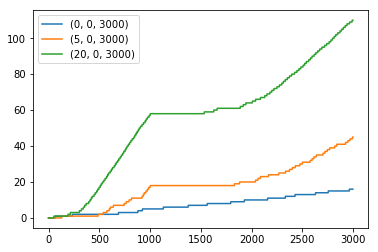

In [12]:
for j, r in enumerate(res):
    plt.plot(r[0], label=N_array[j])
plt.legend()

## Dyna Q for shortcut maze 

In [13]:
steps = 6000
N_array = [(0,1,steps) ,(5,1,steps) ,(20,1,steps)]
with multiprocessing.Pool(4) as p:
    %time res = p.starmap(DynaQ, N_array)

CPU times: user 4.96 ms, sys: 3.2 ms, total: 8.16 ms
Wall time: 3.73 s


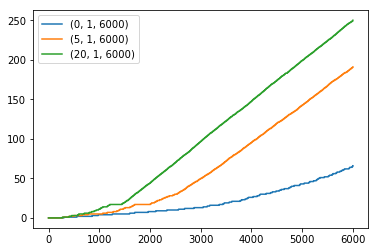

In [14]:
for j, r in enumerate(res):
    plt.plot(r[0], label=N_array[j])
plt.legend()